#### Traditional flow:
    1. Build a ANN
    2. Train it on test set
    3. Give an image as input and netowrk will predict the output.

#### Ensemble Learning:
    1. Build a ANN.
    2. Make mulitple copies of ANN(in this example 5)
    3. Train each ANN individual of others.
    4. Give the same image to all copies of ANN and each ann will have its own prediction.
    
Suppose say there are n copies of the same network. we end up with n predictions from these n different copies for 1 image. How we make a final decision depends on the value of n.

* If value of n is large, the value which most of the networks predicted is the final output.

* If the value of n is small, we take a mean of these predictions and calcualte argmax to extract the class

eg. for a particlar image from mnist dataset, the output from 5 different networks are:

**[0.1  0.0  0.0  0.1  0.0  0.3  0.0  0.5  0.1  0.0  0.0]** argmax => predicted class = 7

**[0.0  0.1  0.2  0.1  0.0  0.1  0.0  0.5  0.0  0.0  0.0]** argmax => predicted class = 7

**[0.6  0.1  0.0  0.1  0.0  0.2  0.0  0.0  0.0  0.0  0.0]** argmax => predicted class = 0

**[0.1  0.0  0.0  0.1  0.0  0.3  0.0  0.4  0.1  0.0  0.0]** argmax => predicted class = 7

**[0.1  0.0  0.0  0.1  0.0  0.3  0.0  0.5  0.1  0.0  0.0]** argmax => predicted class = 7

the mean of predictions looks like:

**[0.18  0.04  0.08  0.10  0.12  0.12  0.18  0.38  0.06  0.00]** argmax => class = 7

this is how the following example calculates predictions for ensemle network.

Note that ensemble network need not be better than the best perfomring network in our bag of ensembles.


In [50]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Helper function for retrieving data from csv



In [5]:
class Data():
    def __init__(self):
        self.size = 0

    def get_xdata(self,x_data_path):
        df = pd.read_csv(x_data_path, sep=',', header=None)
        a = np.array(df).astype(int)
        self.size = len(df)
        a = a.reshape(self.size,28,28)
        self.x_data = a
        return self.x_data

    def get_ydata(self,y_data_path):
        df = pd.read_csv(y_data_path,sep = ',',header = None)
        b = np.array(df).astype(int)
        b = b.reshape(len(df),10)
        self.y_data = b
        return self.y_data

    def get_rand_batch(self,batch_size = None):
        if batch_size is None:
            b_size = 128
        else:
            b_size = batch_size

        rand_indices = np.random.choice(self.size, b_size, replace=False)
        x_batch = self.x_data[rand_indices]
        self.x_batch = x_batch.reshape(b_size, 28, 28, 1)
        self.y_batch = self.y_data[rand_indices]

In [52]:
%%capture
train_data = Data()
train_data.get_xdata("data/x_train.csv")
train_data.get_xdata("data/x_train.csv")

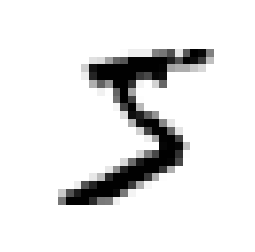

In [55]:
img = train_data.x_data[0].reshape(28,28)
plt.imshow(img,cmap = 'binary')
plt.axis("off")
plt.show()

### Helper function to plot images and  show the true label, predicted,ensembled label on the bottom
adapted from Hvass laboratories

In [44]:
def plot_images(images,y_true_cls,y_pred_cls = None,y_ensemb_cls = None):
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if y_ensemb_cls is None:
        hspace = 1
    else:
        hspace = 1.0
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # For each of the sub-plots.
    for i, ax in enumerate(axes.flat):

        # There may not be enough images for all sub-plots.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i].reshape(28,28), cmap='binary')

            # Show true and predicted classes.
            if (y_ensemb_cls is None):
                if (y_pred_cls is None):
                    xlabel = "True: {0}".format(y_true_cls[i])
                else:
                    msg = "True: {0} \nPredicted: {1}"
                    xlabel = msg.format(y_true_cls[i],y_pred_cls[i])
            else:
                msg = "True: {0}\nNetwork: {1}\nEnsemble: {2}"
                xlabel = msg.format(y_true_cls[i],y_pred_cls[i],y_ensemb_cls[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Now we will define our compuational graph


![alt](https://github.com/thubatilakshmi/Ensemble-Learning/blob/master/network.JPG)

Placeholders for input to graph

In [47]:
x = tf.placeholder('float',shape = [None,28,28,1],name = "x")
y_true = tf.placeholder('float',shape = [None,10],name = "y_true")

In [48]:
y_true_cls = tf.argmax(y_true,axis = 1)